# Supervised classification using classic classifiers

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## The 20 newsgroup dataset
For a description of the dataset, see [https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

State of the art results are available [here](https://paperswithcode.com/dataset/20-newsgroups)

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [3]:
train_data = fetch_20newsgroups(data_home='/Users/flint/Data/sklearn/', random_state=42, 
                          remove=('headers', 'footers', 'quotes'), subset='train')
test_data = fetch_20newsgroups(data_home='/Users/flint/Data/sklearn/', random_state=42, 
                          remove=('headers', 'footers', 'quotes'), subset='test')

In [4]:
print(len(train_data.data), len(test_data.data))

11314 7532


### Examples of contents

In [5]:
from collections import Counter, defaultdict

In [6]:
example = 26
class_size = {}
for class_label, num_docs in Counter(train_data.target).most_common():
    class_size[class_label] = {
        'class_name': train_data.target_names[class_label],
        'size': num_docs
    }
K = pd.DataFrame(class_size).T.sort_index()
K

,class_name,size
0,alt.atheism,480
1,comp.graphics,584
2,comp.os.ms-windows.misc,591
3,comp.sys.ibm.pc.hardware,590
4,comp.sys.mac.hardware,578
5,comp.windows.x,593
6,misc.forsale,585
7,rec.autos,594
8,rec.motorcycles,598
9,rec.sport.baseball,597


In [7]:
print(train_data.data[example])


       Actually, fossil fuel plants run hotter than the usual 
boiling-water reactor nuclear plants.  (There's a gripe in the industry
that nuclear power uses 1900 vintage steam technology).  So it's
more important in nuclear plants to get the cold end of the system
as cold as possible.  Hence big cooling towers.  

       Oil and gas fired steam plants also have condensers, but they
usually are sized to get the steam back into hot water, not most of the
way down to ambient.  Some plants do cool the condensers with water,
rather than air; as one Canadian official, asked about "thermal 
pollution" de-icing a river, said, "Up here, we view heat as a resource".  

       Everybody runs closed-cycle boilers.  The water used is 
purified of solids, which otherwise crud up the boiler plumbing when
the water boils.  Purifying water for boiler use is a bigger job than 
cooling it, so the boiler water is recycled.


In [8]:
print(train_data.target[example], train_data.target_names[train_data.target[example]])

12 sci.electronics


## Tokenizer

**Note**: for a more accurate lemmatization use [spaCy](https://spacy.io)

**Exercize**: Test with different tokenization strategies

In [9]:
from nltk.stem import WordNetLemmatizer

In [10]:
lemmatizer = WordNetLemmatizer()
stops = stopwords.words('english')

In [11]:
lemmatizer.lemmatize('have')

'have'

In [12]:
def tokenize(text):
    return [lemmatizer.lemmatize(x.lower()) for x in 
            nltk.word_tokenize(text) if x not in punctuation and x not in stops]

In [13]:
tokenize(train_data.data[example])[:6]

['actually', 'fossil', 'fuel', 'plant', 'run', 'hotter']

In [22]:
def doc_vocabulary(doc_id, model, vocabulary, top_w=10):
    words_scores = sorted(enumerate(model[doc_id]), key=lambda x: -x[1])
    return [(vocabulary[wid], score) for wid, score in words_scores[:top_w]]

## Vectorizer
**Exercize**: Test with different vectorization strategies

In [14]:
tfidf_model = TfidfVectorizer(tokenizer=tokenize, min_df=10)

In [15]:
X_train_all = tfidf_model.fit_transform(train_data.data)
y_train = train_data.target

In [16]:
X_test_all = tfidf_model.transform(test_data.data)
y_test = test_data.target

In [24]:
doc_vocabulary(example, X_train_all.toarray(), tfidf_model.get_feature_names_out())

[('water', 0.4684782125400617),
 ('plant', 0.46539663191139213),
 ('steam', 0.3170650086216689),
 ('nuclear', 0.26418843251175117),
 ('cooling', 0.20168453480550946),
 ('cold', 0.16619243527007663),
 ('1900', 0.11304554387675865),
 ('fossil', 0.11304554387675865),
 ('boil', 0.11082537614999484),
 ('vintage', 0.11082537614999484)]

## Feature selection
**Exercize**: explore your ideas for feature selection. See [here](https://scikit-learn.org/stable/modules/feature_selection.html) for some of the most common strategies.

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [19]:
selector = SelectKBest(chi2, k=2000) 
X_train = selector.fit_transform(X_train_all, y_train)
X_test = selector.transform(X_test_all)

In [21]:
selector.get_feature_names_out()

array(['x0', 'x13', 'x22', ..., 'x9234', 'x9239', 'x9240'], dtype=object)

In [20]:
X_train.shape

(11314, 2000)

In [28]:
doc_vocabulary(example, X_train.toarray(), selector.get_feature_names_out(
    input_features=tfidf_model.get_feature_names_out()))

[('water', 0.4684782125400617),
 ('plant', 0.46539663191139213),
 ('steam', 0.3170650086216689),
 ('cooling', 0.20168453480550946),
 ('run', 0.1091293651262685),
 ('river', 0.0964439833118951),
 ('tower', 0.0924913842799305),
 ('fired', 0.09085915865551461),
 ('fuel', 0.0872395821245216),
 ('canadian', 0.08627260284473794)]

## Grid search and parameters setting

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
parameters = {'n_neighbors': (5, 10)}
knn = KNeighborsClassifier()
gsearch = GridSearchCV(knn, parameters)

In [32]:
gsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (5, 10)})

In [33]:
for k, v in gsearch.cv_results_.items():
    print(k, v)

mean_fit_time [0.00279889 0.00234227]
std_fit_time [0.00113039 0.00037921]
mean_score_time [0.56743727 0.52848558]
std_score_time [0.01619567 0.02848239]
param_n_neighbors [5 10]
params [{'n_neighbors': 5}, {'n_neighbors': 10}]
split0_test_score [0.34202386 0.33097658]
split1_test_score [0.34821034 0.34688467]
split2_test_score [0.38311975 0.36809545]
split3_test_score [0.37958462 0.35793195]
split4_test_score [0.35057471 0.34394341]
mean_test_score [0.36070266 0.34956641]
std_test_score [0.0171265  0.01263091]
rank_test_score [1 2]


In [35]:
gsearch.best_estimator_.n_neighbors

5

In [36]:
gsearch.best_params_

{'n_neighbors': 5}

## Classify and perform evaluation

In [43]:
import sklearn.metrics as mt

In [47]:
import matplotlib.pyplot as plt

In [41]:
knn_best = gsearch.best_estimator_

KNeighborsClassifier()

In [42]:
y_pred = knn_best.predict(X_test)

In [44]:
report = mt.classification_report(y_true=y_test, y_pred=y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.46      0.23       319
           1       0.17      0.48      0.25       389
           2       0.21      0.39      0.27       394
           3       0.33      0.29      0.31       392
           4       0.32      0.25      0.28       385
           5       0.41      0.29      0.34       395
           6       0.37      0.19      0.25       390
           7       0.32      0.42      0.37       396
           8       0.32      0.42      0.37       398
           9       0.30      0.25      0.27       397
          10       0.44      0.40      0.42       399
          11       0.66      0.18      0.28       396
          12       0.31      0.21      0.25       393
          13       0.31      0.32      0.32       396
          14       0.42      0.34      0.38       394
          15       0.49      0.29      0.36       398
          16       0.53      0.26      0.34       364
          17       0.78    

In [52]:
cm = mt.confusion_matrix(y_test, y_pred)
cmd = mt.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=test_data.target_names)

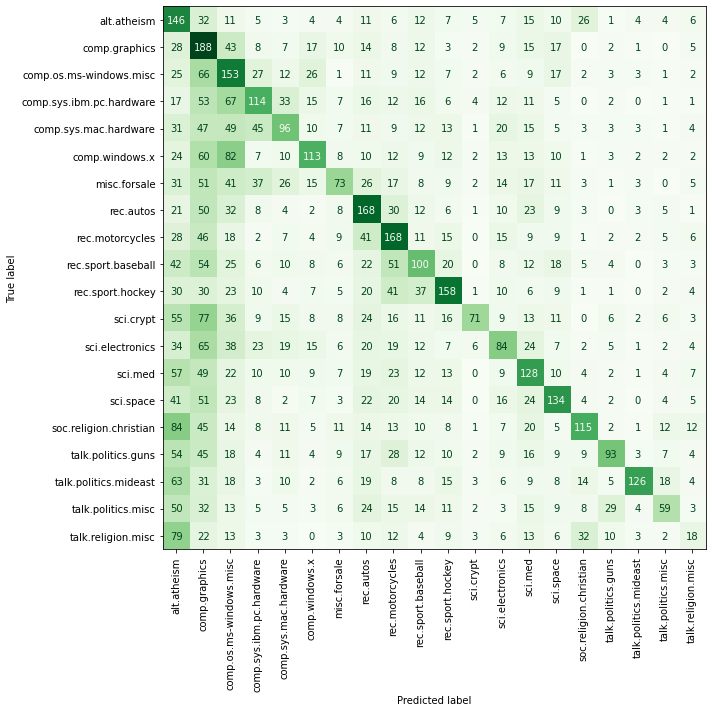

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax, values_format='d', cmap='Greens', xticks_rotation='vertical', colorbar=False)
plt.tight_layout()
plt.show()